# Coursework MOD006203: Systems Biology Lab Report- 1802377

This exploratory analysis is based on RNA sequencing data from a study on *SIAH2* as a circadian regulator in mice (Mekbib, T., 2022).

Mekbib T, Suen T-C, Rollins-Hairston A, Smith K, Armstrong A, Gray C, et al, 2022. The ubiquitin ligase SIAH2 is a female-specific regulator of circadian rhythms and metabolism. *PLoS Genet* 18(7). https://doi.org/10.1371/journal

The first thing to do is set up Conda, which will allow easy installation of the command line tools to be used.

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 
import sys 
sys.path.append('/usr/local/lib/python3.7/site-packages/')

Next, the command line tools are installed. FastQC (https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) provides quality control metrics and visualisations for FASTQ files. The FASTQ reads can then be trimmed with Trimmomatic (http://www.usadellab.org/cms/?page=trimmomatic) to increase quality.


In [ ]:
! conda install -c bioconda fastqc -y
! conda install -c bioconda trimmomatic -y

Before downloading the FASTQ files containing the RNA sequencing data from the study, create a directory to store them.

In [3]:
! mkdir data

The FASTQ files are available under GSE182835 on the NCBI Gene Expression Omnibus (GEO) (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE182835) and can be downloaded via the Sequence Read Archive FTP service. A single-end FASTQ file is downloaded for 1 mouse of each sex and genotype (wildtype and *SIAH2*-knockout) taken from the same timepoint (ZT10) to compare gene expression. There were 3 mice for each condition in the study, but for simplicity only 1 is used for now.

In [ ]:
! wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR156/051/SRR15620651/SRR15620651.fastq.gz -O data/male_wt.fastq.gz
! wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR156/054/SRR15620654/SRR15620654.fastq.gz -O data/male_ko.fastq.gz
! wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR156/057/SRR15620657/SRR15620657.fastq.gz -O data/female_wt.fastq.gz
! wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR156/060/SRR15620660/SRR15620660.fastq.gz -O data/female_ko.fastq.gz

Run FASTQC on all the FASTQ files. This takes a little while but will output a HTML file and a compressed folder of more files for each FASTQ.

In [ ]:
! fastqc data/*.fastq.gz

Viewing the HTML files reveals some quality issues, so Trimmomatic will be used to improve this. This command will trim reads at the start and end with quality below 3, as well as cutting where there is a region of 4 bases of average quality below 15. Reads of less than 36 bases will be dropped.

In [6]:
! trimmomatic SE -phred33 data/male_wt.fastq.gz data/male_wt_trimmed.fastq.gz LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
! trimmomatic SE -phred33 data/male_ko.fastq.gz data/male_ko_trimmed.fastq.gz LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
! trimmomatic SE -phred33 data/female_wt.fastq.gz data/female_wt_trimmed.fastq.gz LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
! trimmomatic SE -phred33 data/female_ko.fastq.gz data/female_ko_trimmed.fastq.gz LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

TrimmomaticSE: Started with arguments:
 -phred33 data/male_wt.fastq.gz data/male_wt_trimmed.fastq.gz LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
Automatically using 2 threads
Input Reads: 2282488 Surviving: 2201078 (96.43%) Dropped: 81410 (3.57%)
TrimmomaticSE: Completed successfully
TrimmomaticSE: Started with arguments:
 -phred33 data/male_ko.fastq.gz data/male_ko_trimmed.fastq.gz LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
Automatically using 2 threads
Input Reads: 4262228 Surviving: 4122999 (96.73%) Dropped: 139229 (3.27%)
TrimmomaticSE: Completed successfully
TrimmomaticSE: Started with arguments:
 -phred33 data/female_wt.fastq.gz data/female_wt_trimmed.fastq.gz LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
Automatically using 2 threads
Input Reads: 5091715 Surviving: 4955551 (97.33%) Dropped: 136164 (2.67%)
TrimmomaticSE: Completed successfully
TrimmomaticSE: Started with arguments:
 -phred33 data/female_ko.fastq.gz data/female_ko_trimmed.fastq.gz LEADING:3 TRAILI

In order to map reads to transcripts, the trimmed FASTQS must be aligned to the *Mus musculus* reference genome. This is downloaded from Ensembl via FTP.

In [ ]:
! wget ftp://ftp.ensembl.org/pub/release-107/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz -O data/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz

R will be used for this part of the analysis, so R magic needs to be set up.

In [8]:
%load_ext rpy2.ipython 

Next, the required packages are installed and loaded. Bioconductor (https://www.bioconductor.org/) is used to install Rsubread (https://bioconductor.org/packages/release/bioc/html/Rsubread.html) for handling RNA sequencing data, and DESeq2 (https://bioconductor.org/packages/release/bioc/html/DESeq2.html) for differential gene expression analysis. ggpubr (https://cran.r-project.org/web/packages/ggpubr/index.html) is used to plot sophisticated graphs and visualisations.

In [ ]:
%%R
install.packages('BiocManager')
BiocManager::install('Rsubread')
BiocManager::install('DESeq2')
install.packages('ggpubr')
library(Rsubread)
library('DESeq2')
library(ggpubr)

Now the reference index is built using Rsubread to allow quick access to the reference genome during alignment. It is gapped to reduce memory usage.

In [ ]:
%%R
buildindex(basename='data/reference_index', reference='data/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz', gappedIndex=TRUE)

Align each trimmed FASTQ to the reference genome to produce binary alignment files with Rsubread.

In [ ]:
%%R
align(index='data/reference_index', readfile1='data/male_wt_trimmed.fastq.gz', output_file='data/male_wt.BAM')
align(index='data/reference_index', readfile1='data/male_ko_trimmed.fastq.gz', output_file='data/male_ko.BAM')
align(index='data/reference_index', readfile1='data/female_wt_trimmed.fastq.gz', output_file='data/female_wt.BAM')
align(index='data/reference_index', readfile1='data/female_ko_trimmed.fastq.gz', output_file='data/female_ko.BAM')

Rsubread then counts reads in each BAM file belonging to each gene or genomic feature in the inbuilt mm39 annotation. Count the male mice and female mice together.

In [ ]:
%%R
male_counts <- featureCounts(c('data/male_wt.BAM', 'data/male_ko.BAM'), annot.inbuilt='mm39')
female_counts <- featureCounts(c('data/female_wt.BAM', 'data/female_ko.BAM'), annot.inbuilt='mm39')

DESeq2 relies on replicates to estimate the dispersion of counts around the expected value for each condition. The count data from this study with 3 mice for each condition is also available in CSV format on GEO, so that data will be used from now. Download and unzip the CSVs.

In [ ]:
! wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE182nnn/GSE182835/suppl/GSE182835_WT_Siah2_FEMALE_liver.deseq.counts.csv.gz -O data/female_counts.csv.gz
! wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE182nnn/GSE182835/suppl/GSE182835_WT_Siah2_MALE_liver.deseq.counts.csv.gz -O data/male_counts.csv.gz
! gunzip data/*.csv.gz

The CSV data is read into a dataframe. Some genes have been converted to dates and can't be reliably converted back so are removed.

In [13]:
%%R
male_counts <- read.csv('data/male_counts.csv')
female_counts <- read.csv('data/female_counts.csv')
male_counts <- subset(male_counts, !grepl('-Mar|-Sep', male_counts$X))
female_counts <- subset(female_counts, !grepl('-Mar|-Sep', female_counts$X))

The male and female count data is put into a format for DESeq2, using the sample names and corresponding genotypes as metadata. The design is the condition to test, in this case genotype, and tidy is set to TRUE as the first column in count data is the genes. Re-levelling is applied to ensure the wildtype genotype is used as the reference, else it would default to knockout.

In [14]:
%%R
coldata <- data.frame(sample=c('WTM.1087', 'WTM.1055', 'WTM.1086', 'KOM.1076', 'KOM.1081', 'KOM.1075'), genotype=c('wildtype', 'wildtype', 'wildtype', 'knockout', 'knockout', 'knockout'))
male_dds <- DESeqDataSetFromMatrix(countData=male_counts, colData=coldata, design=~genotype, tidy=TRUE)
male_dds$genotype <- relevel(male_dds$genotype, ref='wildtype')
coldata <- data.frame(sample=c('WTF.1091', 'WTF.1090', 'WTF.1089', 'KOF.1104', 'KOF.1070', 'KOF.1105'), genotype=c('wildtype', 'wildtype', 'wildtype', 'knockout', 'knockout', 'knockout'))
female_dds <- DESeqDataSetFromMatrix(countData=female_counts, colData=coldata, design=~genotype, tidy=TRUE)
female_dds$genotype <- relevel(female_dds$genotype, ref='wildtype')

DESeq2 is then run for males and females. This performs differential gene expression analysis, using a generalized linear model based on the negative binomial distribution. The Wald statistical test is used to determine significance. The first rows of the results tables produced are shown.

In [21]:
%%R
male_results <- results(DESeq(male_dds))
head(male_results)

log2 fold change (MLE): genotype knockout vs wildtype 
Wald test p-value: genotype knockout vs wildtype 
DataFrame with 6 rows and 6 columns
         baseMean log2FoldChange     lfcSE       stat    pvalue      padj
        <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
Xkr4     0.000000             NA        NA         NA        NA        NA
Rp1      0.306483     -1.5531257  4.070934 -0.3815158  0.702821  0.999872
Sox17    7.476014     -1.0276784  0.816659 -1.2583943  0.208249  0.999872
Mrpl15 112.966581      0.1082478  0.233678  0.4632342  0.643196  0.999872
Lypla1 220.466866      0.0129183  0.190029  0.0679806  0.945801  0.999872
Tcea1   45.869779      0.2490781  0.361688  0.6886542  0.491041  0.999872


In [22]:
%%R
female_results <- results(DESeq(female_dds))
head(female_results)

log2 fold change (MLE): genotype knockout vs wildtype 
Wald test p-value: genotype knockout vs wildtype 
DataFrame with 6 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat    pvalue      padj
        <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
Xkr4     0.000000             NA        NA        NA        NA        NA
Rp1      0.448876     -2.1816531  2.933850 -0.743614  0.457110        NA
Sox17    3.152223     -0.3317260  1.186479 -0.279589  0.779793        NA
Mrpl15 187.130870      0.0702773  0.258007  0.272385  0.785326  0.956605
Lypla1 205.751843      0.0860996  0.340006  0.253230  0.800091  0.960661
Tcea1   51.142324     -0.0691422  0.382270 -0.180873  0.856468  0.975101


This shows genes that are differentially expressed in wildtype vs *SIAH2*-knockout mice. Results will now be visualised with ggpubr ggmaplot using an accepted false discovery rate of 0.05, accepted fold change of 2 and point size of 0.4. The top differentially expressed are labelled on the graph.

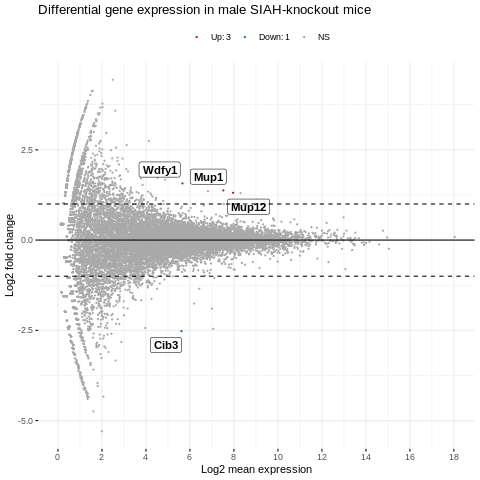

In [24]:
%%R
ggmaplot(male_results, main='Differential gene expression in male SIAH-knockout mice',
   fdr=0.05, fc=2, size=0.4,
   genenames=as.vector(male_results$X),
   font.label='bold', label.rectangle=TRUE,
   legend='top', ggtheme=ggplot2::theme_minimal())

Plot individual counts for each genotype for 2 of the genes shown.

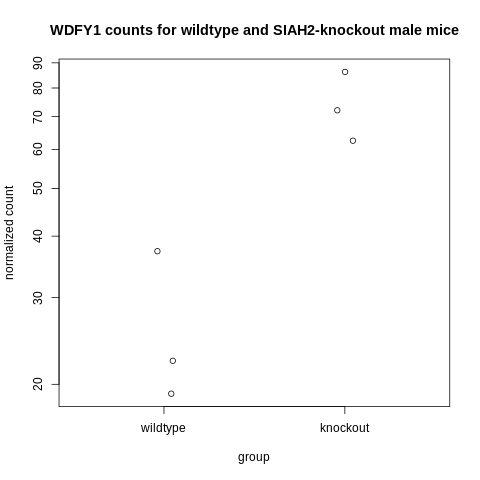

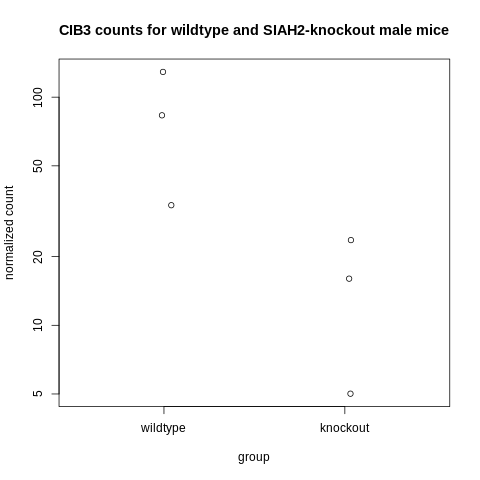

In [27]:
%%R
plotCounts(male_dds, gene='Wdfy1', intgroup='genotype', main='WDFY1 counts for wildtype and SIAH2-knockout male mice')
plotCounts(male_dds, gene='Cib3', intgroup='genotype', main='CIB3 counts for wildtype and SIAH2-knockout male mice')

Repeat for female mice.

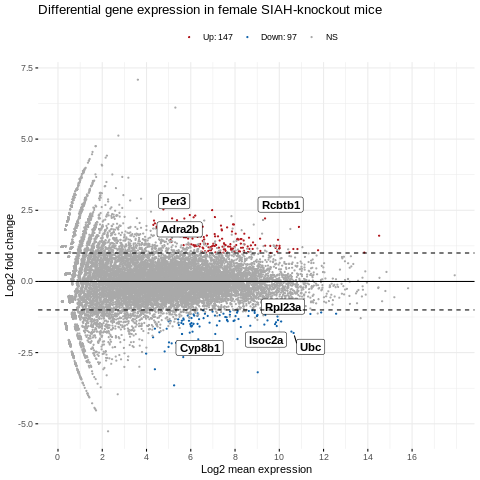

In [28]:
%%R
ggmaplot(female_results, main='Differential gene expression in female SIAH-knockout mice',
   fdr=0.05, fc=2, size=0.4,
   genenames=as.vector(female_results$X),
   font.label='bold', label.rectangle=TRUE,
   legend='top', ggtheme=ggplot2::theme_minimal())

The female mice appear to have a lot more differential expression. Look at counts for a highly upregulated and downregulated gene.

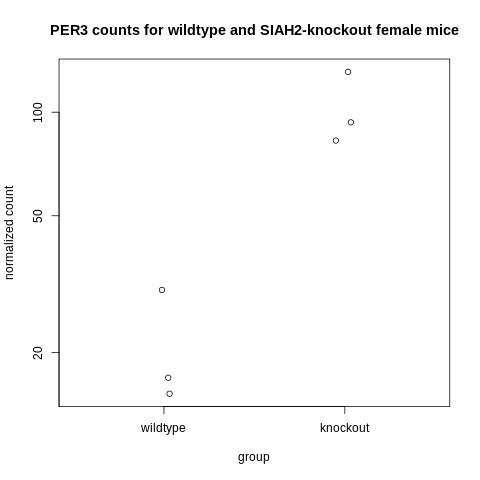

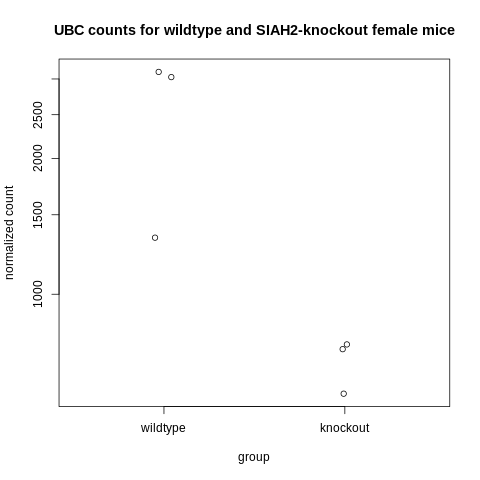

In [29]:
%%R
plotCounts(female_dds, gene='Per3', intgroup='genotype', main='PER3 counts for wildtype and SIAH2-knockout female mice')
plotCounts(female_dds, gene='Ubc', intgroup='genotype', main='UBC counts for wildtype and SIAH2-knockout female mice')

Export the DESeq2 results to CSVs.

In [30]:
%%R
write.csv(male_results, 'data/male_deseq.csv')
write.csv(female_results, 'data/female_deseq.csv')

Next, Python tool RNAlysis (https://pypi.org/project/RNAlysis/) will be used to filter the DESeq2 data. It utilises Pandas dataframes which have NumPy arrays as columns. Install and import it.

In [ ]:
! pip install rnalysis
from rnalysis import filtering

Start by filtering the male data. NA is assigned to genes that have outliers or don't meet the filter threshold, so remove these missing values first. Next, filter out genes with adjusted p-values that fall below the 0.05 significance threshold. Finally, filter out genes that have a log2 fold change below 1, indicating only a small change in expression.

In [32]:
male_filter = filtering.DESeqFilter("data/male_deseq.csv")
male_filter.filter_missing_values()
male_filter.filter_significant(alpha=0.05)
male_filter.filter_abs_log2_fold_change(abslog2fc=1)

Filtered 7198 features, leaving 16195 of the original 23393 features. Filtered inplace.
Filtered 16189 features, leaving 6 of the original 16195 features. Filtered inplace.
Filtered 2 features, leaving 4 of the original 6 features. Filtered inplace.


There were only 4 genes meeting these criteria for the male mice, but the plots suggested there would be more for females.

In [33]:
female_filter = filtering.DESeqFilter("data/female_deseq.csv")
female_filter.filter_missing_values()
female_filter.filter_significant(alpha=0.05)
female_filter.filter_abs_log2_fold_change(abslog2fc=1)

Filtered 15047 features, leaving 8346 of the original 23393 features. Filtered inplace.
Filtered 8046 features, leaving 300 of the original 8346 features. Filtered inplace.
Filtered 56 features, leaving 244 of the original 300 features. Filtered inplace.


As predicted, there are a lot more differentially expressed genes as a result of *SIAH2* knockout for female mice, which is what the study found too. Save the filtered CSV files, which can then be used to build a network in Cytoscape and look at interactions. This might help with understanding results.

In [34]:
male_filter.save_csv()
female_filter.save_csv()

As seen in the plot earlier, one of the top upregulated genes in female mice was *PER3*, a circadian gene. To understand how this might impact circadian rhythms, download a mammalian circadian clock model by Leloup and Goldbeter, 2004, under BIOMD0000000975 on BioModels (https://www.ebi.ac.uk/biomodels/).

Leloup, J.-C. and Goldbeter, A., 2004. Modeling the mammalian circadian clock: Sensitivity analysis and multiplicity of oscillatory mechanisms. *Journal of theoretical biology*, 230(4), pp.541–562. https://doi.org/10.1016/j.jtbi.2004.04.040

In [ ]:
! wget https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000975.5?filename=Leloup2004_Set1.xml -O data/circadian_model.xml

In order to convert this model to a format for Python, SBMLtoODEpy (https://github.com/AnabelSMRuggiero/sbmltoodepy) will be installed and imported, along with NumPy (https://numpy.org/) and Matplotlib (https://matplotlib.org/) for visualisation.

In [ ]:
! pip install sbmltoodepy
import sbmltoodepy
import numpy as np
import matplotlib.pyplot as plt

First, load the model into Python. This creates a class in the specified file, which is imported. An instance of this class is then created.

In [37]:
sbmltoodepy.ParseAndCreateModel("data/circadian_model.xml", outputFilePath="CircadianFile.py", className="CircadianModel")
from CircadianFile import CircadianModel
circadian_model = CircadianModel()

Print the keys for the parameters, species and compartments for the model.

In [38]:
print(circadian_model.p.keys())
print(circadian_model.s.keys())
print(circadian_model.c.keys())

dict_keys(['MP', 'vsP', 'vmP', 'kdmp', 'KAP', 'KmP', 'MC', 'vsC', 'vmC', 'kdmc', 'KAC', 'KmC', 'MB', 'vsB', 'vmB', 'kdmb', 'KIB', 'KmB', 'PC', 'CC', 'PCP', 'CCP', 'PCC', 'PCN', 'PCCP', 'PCNP', 'BC', 'BCP', 'BN', 'BNP', 'IN', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'kdnc', 'kdn', 'kstot', 'ksB', 'ksC', 'ksP', 'm', 'n', 'vstot', 'Kd', 'Kdp', 'Kp', 'Vphos', 'V1B', 'V1C', 'V1P', 'V1PC', 'V2B', 'V2C', 'V2P', 'V2PC', 'V3B', 'V3PC', 'V4B', 'V4PC', 'vdBC', 'vdBN', 'vdCC', 'vdIN', 'vdPC', 'vdPCC', 'vdPCN'])
dict_keys(['MP_0', 'MC_0', 'MB_0', 'PC_0', 'CC_0', 'PCP_0', 'CCP_0', 'PCC_0', 'PCN_0', 'PCNP_0', 'PCCP_0', 'BC_0', 'BCP_0', 'BN_0', 'BNP_0', 'IN_0', 'BTot', 'CTot', 'PTot'])
dict_keys(['Compartment'])


Define a function to run and plot a simulation of the model over 24hrs for a particular species. This uses NumPy arrays to store the times and concentrations at each interval.



In [39]:
def plot_model(species, model):
  times = np.zeros(25)
  times[0] = model.time
  concentrations = np.zeros(25)
  concentrations[0] = model.s[species].concentration
  for i in range(24):
    model.RunSimulation(1)
    times[i+1] = model.time
    concentrations[i+1] = model.s[species].concentration
  plt.plot(times, concentrations, label=species)
  plt.xlabel('Time (hours)')
  plt.ylabel('Species concentration')
  plt.legend(bbox_to_anchor=(1, 1))

Use the function to plot the model for each species.

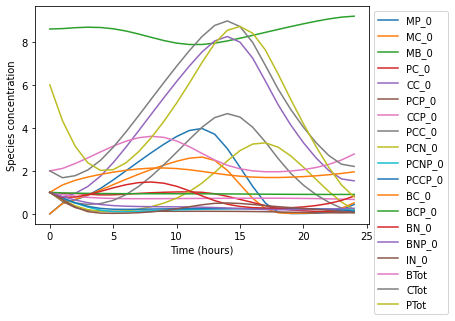

In [40]:
for species in circadian_model.s.keys():
  # reset model
  circadian_model = CircadianModel()
  plot_model(species, circadian_model)

As *PER3* is upregulated, the vsP parameter, which is the maximum rate of *PER* mRNA synthesis can be increased in an attempt to simulate the effect of this. This parameter combines *PER1*, *PER2* and *PER3* genes so may not be accurate, but it is still interesting to look at. There are warnings due to the changed parameter.

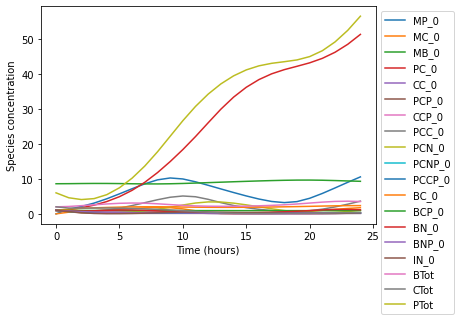

In [41]:
for species in circadian_model.s.keys():
  # reset model
  circadian_model = CircadianModel()
  circadian_model.p['vsP'] = sbmltoodepy.modelclasses.Parameter(3, 'vsP', True, metadata = sbmltoodepy.modelclasses.SBMLMetadata('vsP'))
  plot_model(species, circadian_model)

Although this may not really represent the effect of *PER3* upregulation on the circadian system seen in female mice, it does show the potential it has to cause significant disruption. The study reported changes in metabolism of the female mice which might come as a result of a change like this. More investigation is needed to determine the role of *SIAH2* and why it appears to be so different between sexes, but what this has clearly shown is that mechanisms found in one sex cannot always be applied to the other.

The filtered female DESeq2 output CSV can be found on GitHub: https://github.com/bethsampher/systems-biology-coursework